# Análisis Exploratorio de Datos
## Sistema de Monitoreo para Personas Sordas

In [15]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from database_connection import execute_query

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

## 1. Cargar Datos

In [16]:
with open('../data/02_extract_features.sql', 'r') as f:
    query = f.read()

data = execute_query(query)
df = pd.DataFrame(data)

numeric_columns = [
    'completion_rate', 'abandonment_rate', 'avg_frustration',
    'avg_visual_attention', 'avg_visual_fatigue', 
    'distraction_events_per_hour', 'drowsiness_events_per_hour',
    'avg_pause_count', 'intervention_count_per_activity',
    'avg_engagement_score', 'response_to_video', 'response_to_text',
    'response_to_vibration', 'avg_activity_duration_minutes',
    'preference_easy_activities', 'performance_hard_activities'
]

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Datos cargados: {df.shape[0]} usuarios, {df.shape[1]} features")
df.head()

Datos cargados: 101 usuarios, 17 features


,user_id,completion_rate,abandonment_rate,avg_frustration,avg_visual_attention,avg_engagement_score,distraction_events_per_hour,drowsiness_events_per_hour,avg_visual_fatigue,avg_pause_count,avg_activity_duration_minutes,intervention_count_per_activity,response_to_video,response_to_text,response_to_vibration,preference_easy_activities,performance_hard_activities
0,101,0.9231,0.0000,0.807666,100.000000,3.0000,0.0000,0.0000,0.0000,0.0769,1.4167,0.3846,0.6000,0.2000,0.0000,0.0000,0.0000
1,1001,0.8556,0.1444,0.196859,77.822889,1.8652,0.0590,0.0075,0.3417,2.0444,11.6753,2.2000,0.2374,0.2475,0.2323,1.0000,0.8800
2,1002,0.8706,0.1294,0.198501,77.732073,1.9135,0.0529,0.0061,0.3571,2.0471,11.8108,1.9412,0.2061,0.2424,0.3030,0.9524,0.8182
3,1003,0.7935,0.2065,0.220783,77.558021,1.8697,0.0426,0.0053,0.3461,1.9891,11.1096,1.7609,0.2346,0.3395,0.1975,0.8000,0.7200
4,1004,0.8191,0.1809,0.226079,77.762935,1.8903,0.0432,0.0051,0.3149,2.0106,11.8052,2.0106,0.2540,0.2275,0.2434,0.8462,0.7727


## 2. Inspección Básica

In [17]:
print("Información del DataFrame:")
df.info()

print("\nValores nulos:")
print(df.isnull().sum())

print("\nEstadísticas descriptivas:")
df.describe()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   user_id                          101 non-null    int64  
 1   completion_rate                  101 non-null    float64
 2   abandonment_rate                 101 non-null    float64
 3   avg_frustration                  101 non-null    float64
 4   avg_visual_attention             101 non-null    float64
 5   avg_engagement_score             101 non-null    float64
 6   distraction_events_per_hour      101 non-null    float64
 7   drowsiness_events_per_hour       101 non-null    float64
 8   avg_visual_fatigue               101 non-null    float64
 9   avg_pause_count                  101 non-null    float64
 10  avg_activity_duration_minutes    101 non-null    float64
 11  intervention_count_per_activity  101 non-null    float64


,user_id,completion_rate,abandonment_rate,avg_frustration,avg_visual_attention,avg_engagement_score,distraction_events_per_hour,drowsiness_events_per_hour,avg_visual_fatigue,avg_pause_count,avg_activity_duration_minutes,intervention_count_per_activity,response_to_video,response_to_text,response_to_vibration,preference_easy_activities,performance_hard_activities
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.00000,101.000000,101.000000
mean,1041.099010,0.616148,0.383092,0.320902,67.254226,1.659885,0.043756,0.002271,0.328564,5.441230,11.463159,1.529788,0.285086,0.160625,0.27953,0.621446,0.598676
std,98.790132,0.182746,0.184192,0.087785,8.686288,0.211266,0.028724,0.002173,0.038684,2.643388,1.549367,0.335929,0.060043,0.113138,0.09810,0.203127,0.226799
min,101.000000,0.270300,0.000000,0.191620,55.129902,1.426800,0.000000,0.000000,0.000000,0.076900,1.416700,0.384600,0.145500,0.000000,0.00000,0.000000,0.000000
25%,1025.000000,0.440000,0.205900,0.270146,57.485083,1.508700,0.030300,0.000900,0.317200,2.215400,10.826100,1.309500,0.245900,0.000000,0.22480,0.500000,0.428600
50%,1050.000000,0.630100,0.369900,0.323011,69.117600,1.615100,0.041300,0.001500,0.331300,4.600000,11.471400,1.542400,0.280500,0.200000,0.26030,0.666700,0.625000
75%,1075.000000,0.794100,0.560000,0.379522,76.987289,1.865200,0.051200,0.002900,0.346200,7.750000,12.300000,1.773600,0.315800,0.245900,0.32610,0.764700,0.782600
max,1100.000000,0.923100,0.729700,0.807666,100.000000,3.000000,0.283100,0.015400,0.377600,9.500000,14.818200,2.200000,0.600000,0.339500,0.55930,1.000000,0.954500


## 3. Distribución de Features

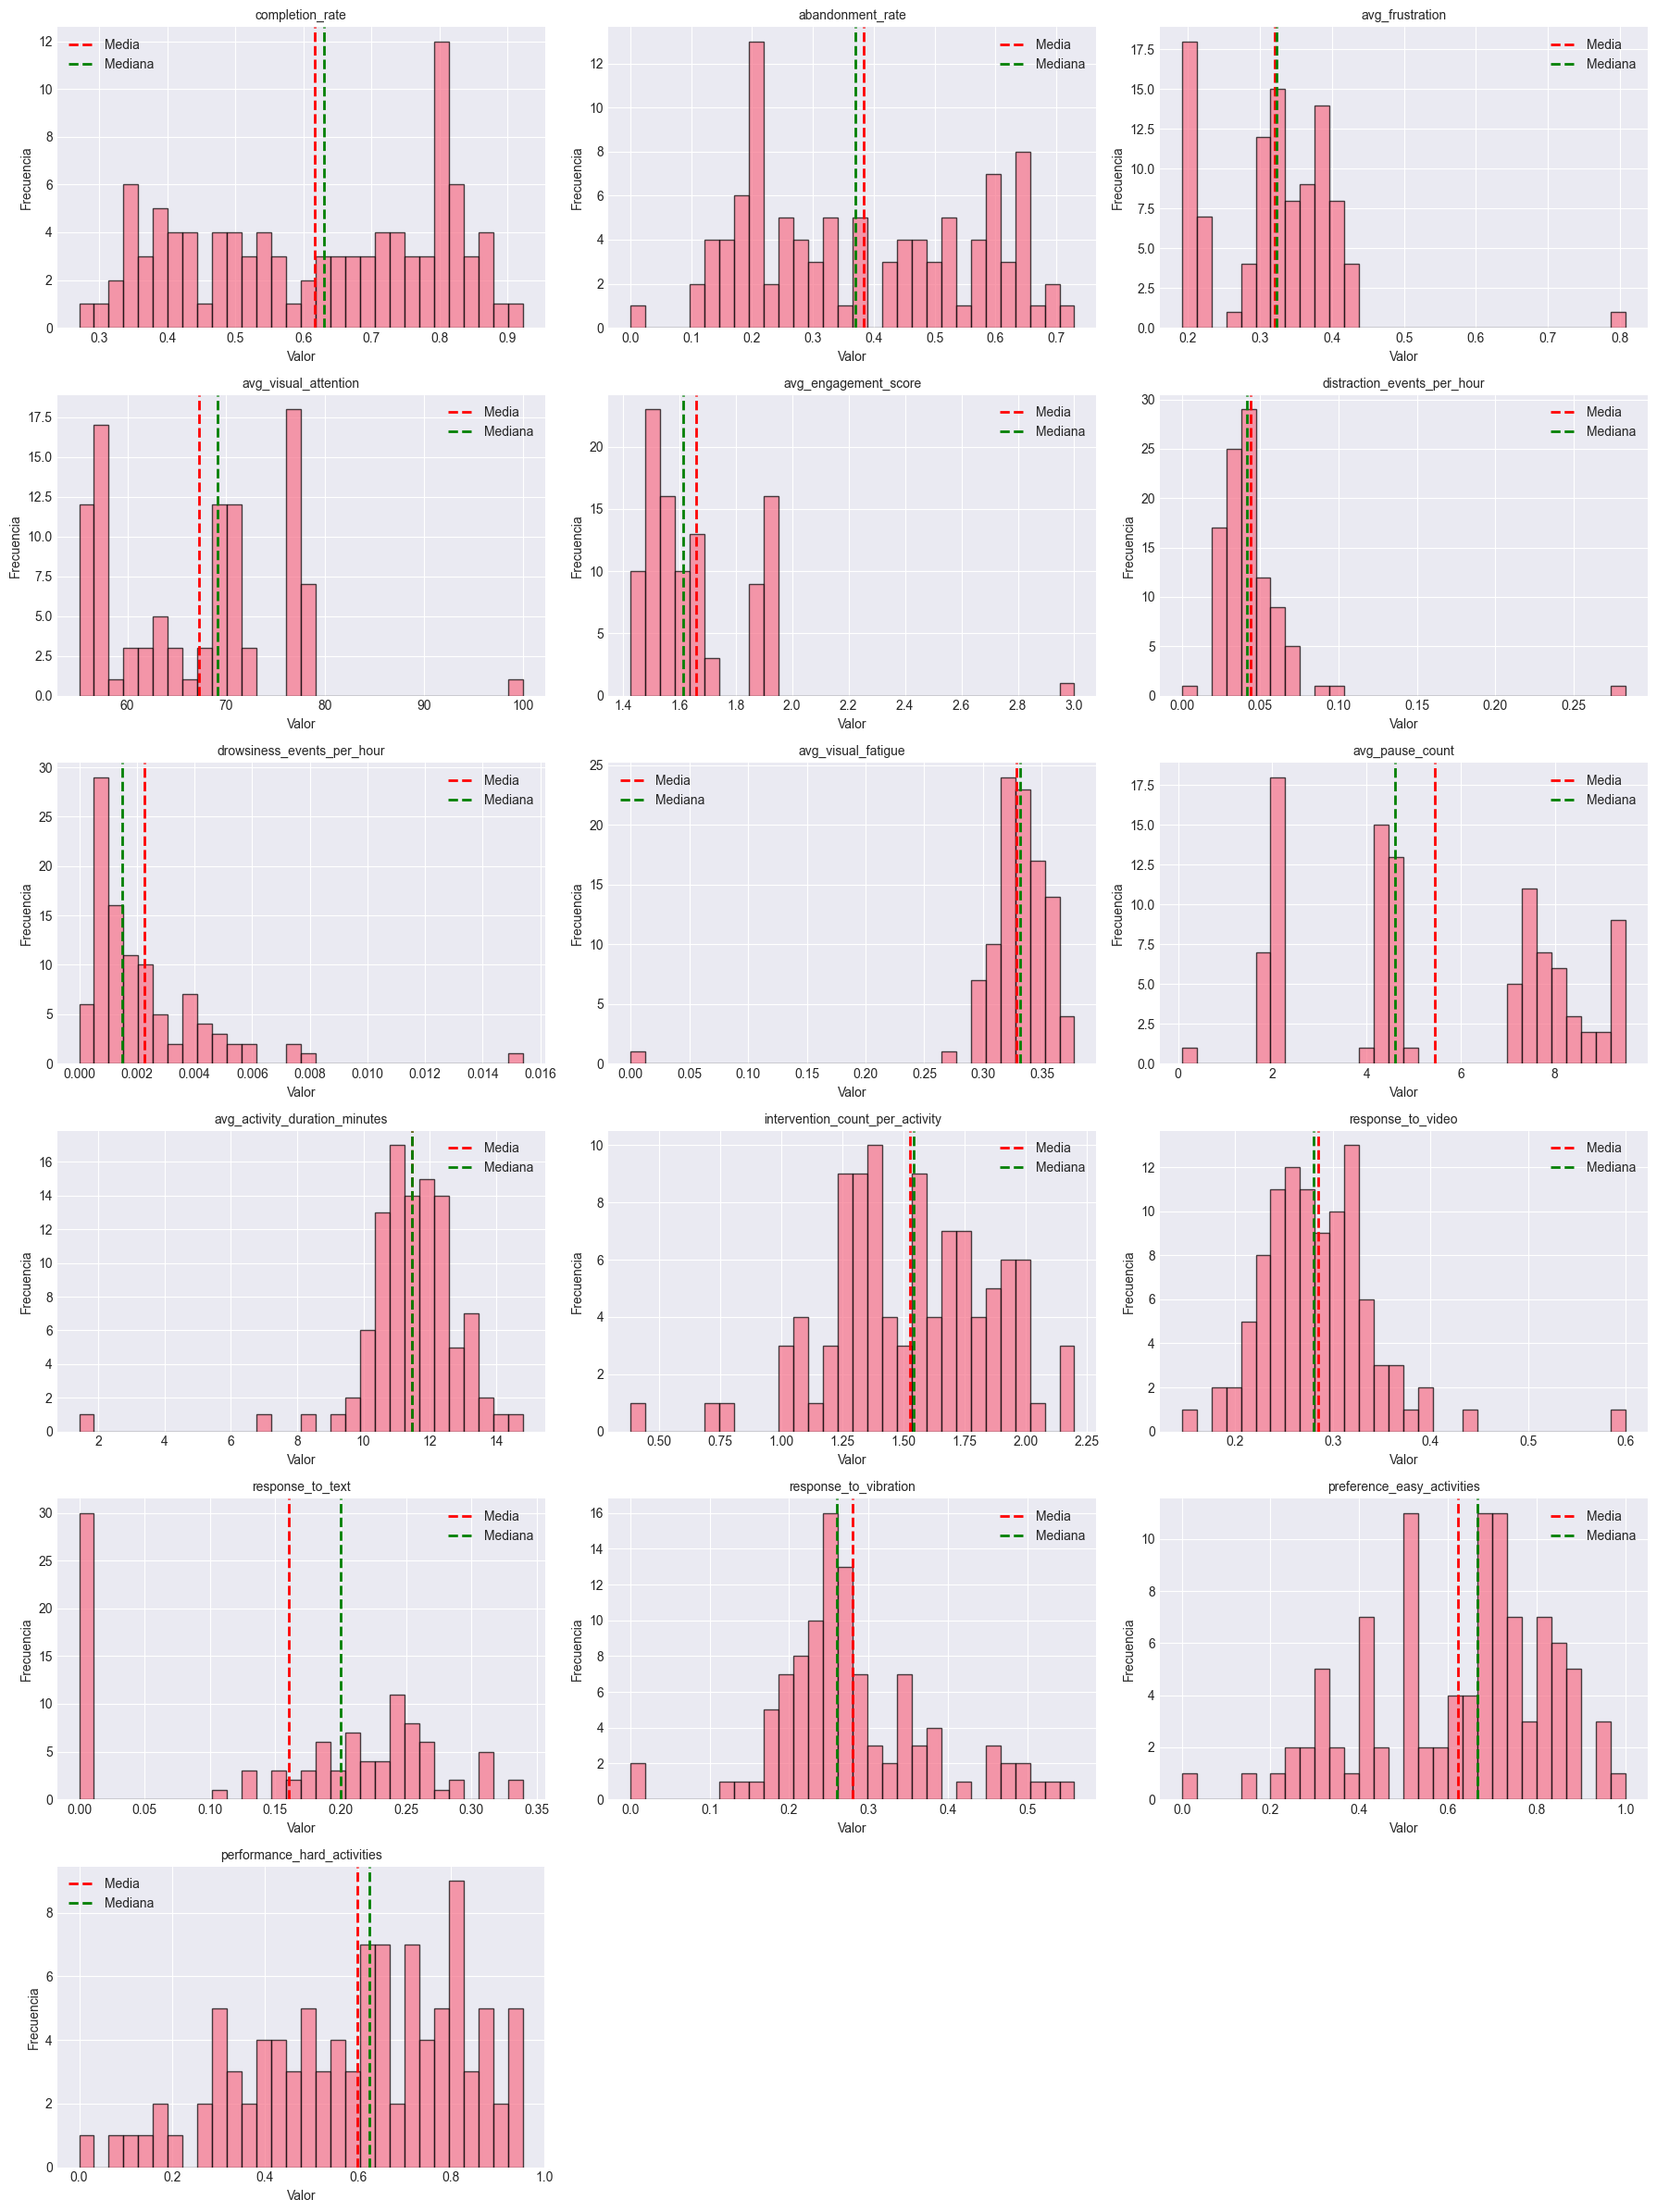

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('user_id')

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('Valor')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label='Media')
    axes[idx].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
    axes[idx].legend()

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('../output/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Matriz de Correlación

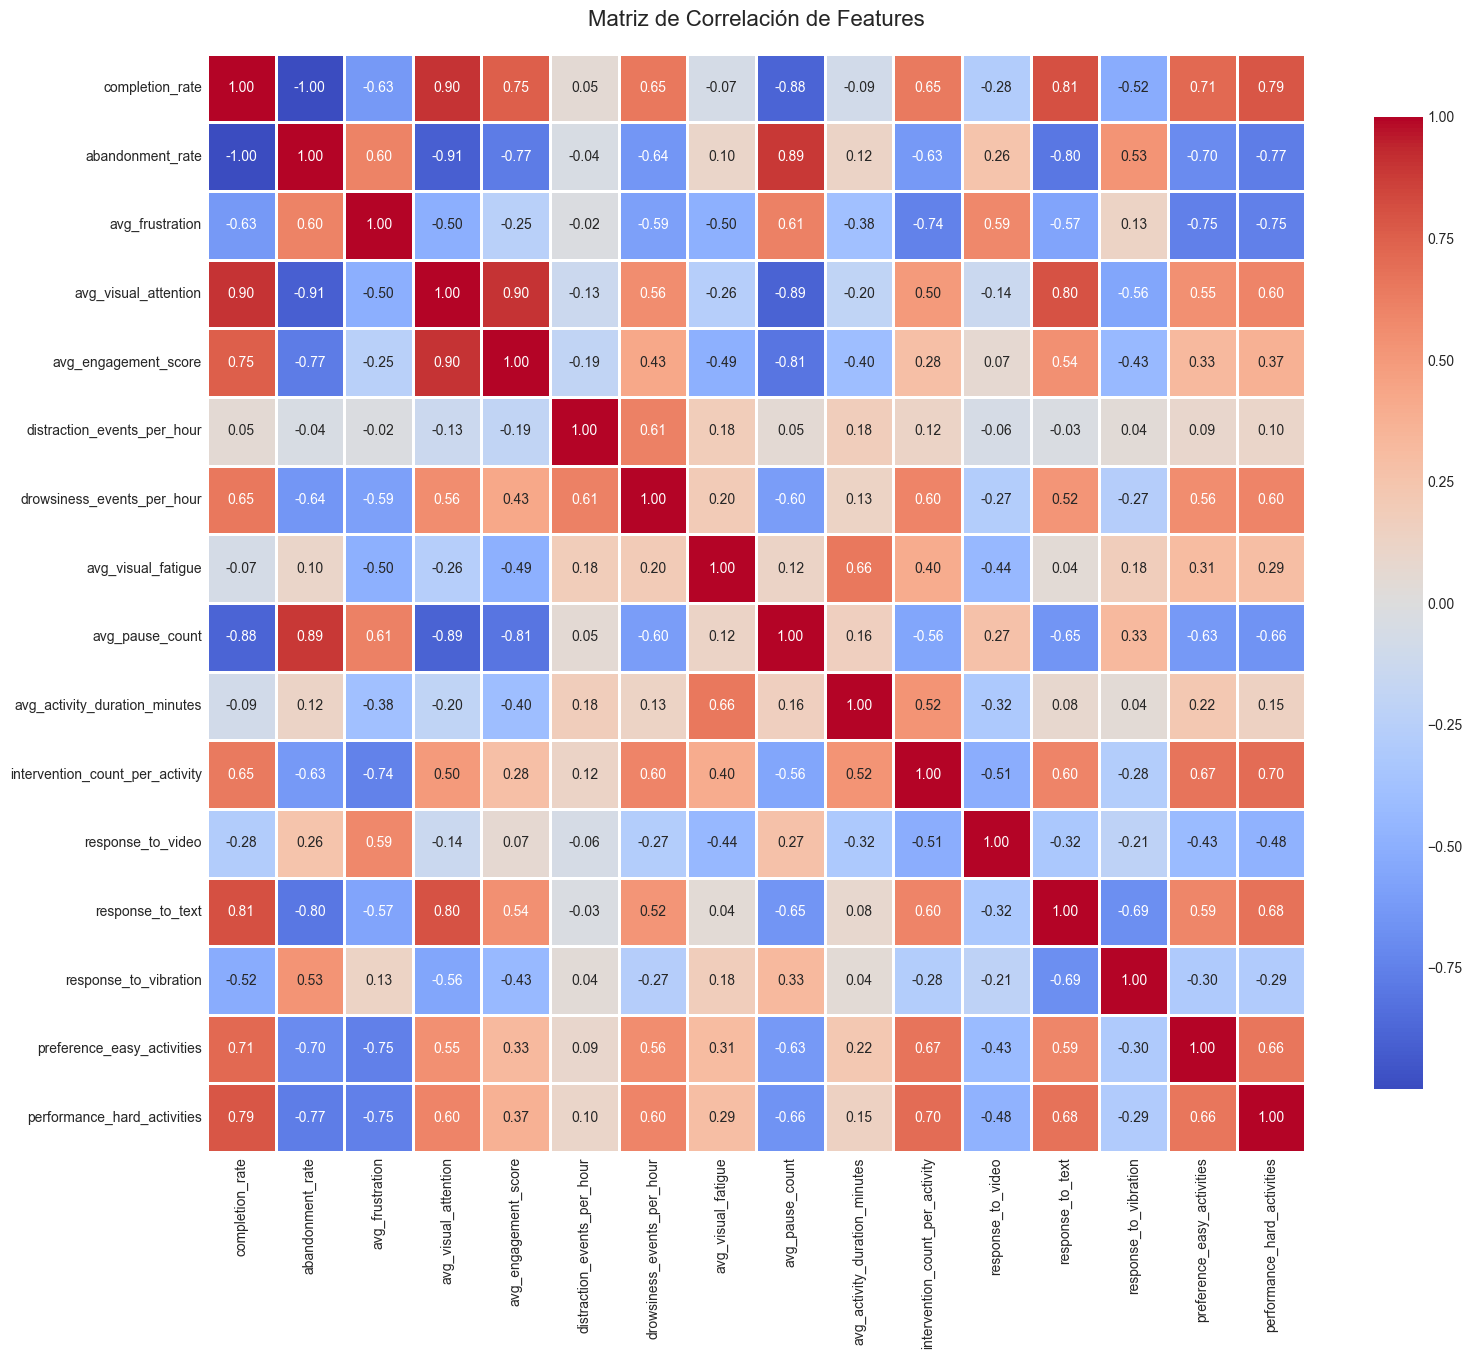


Correlaciones más fuertes (|r| > 0.5):
                          Feature 1                        Feature 2  \
0                   completion_rate                 abandonment_rate   
12                 abandonment_rate             avg_visual_attention   
28             avg_visual_attention             avg_engagement_score   
2                   completion_rate             avg_visual_attention   
30             avg_visual_attention                  avg_pause_count   
15                 abandonment_rate                  avg_pause_count   
5                   completion_rate                  avg_pause_count   
35             avg_engagement_score                  avg_pause_count   
7                   completion_rate                 response_to_text   
31             avg_visual_attention                 response_to_text   
17                 abandonment_rate                 response_to_text   
10                  completion_rate      performance_hard_activities   
13                 aband

In [19]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Features', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('../output/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelaciones más fuertes (|r| > 0.5):")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

corr_df = pd.DataFrame(corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlación'])
corr_df = corr_df.sort_values('Correlación', key=abs, ascending=False)
print(corr_df)

## 5. Detección de Outliers

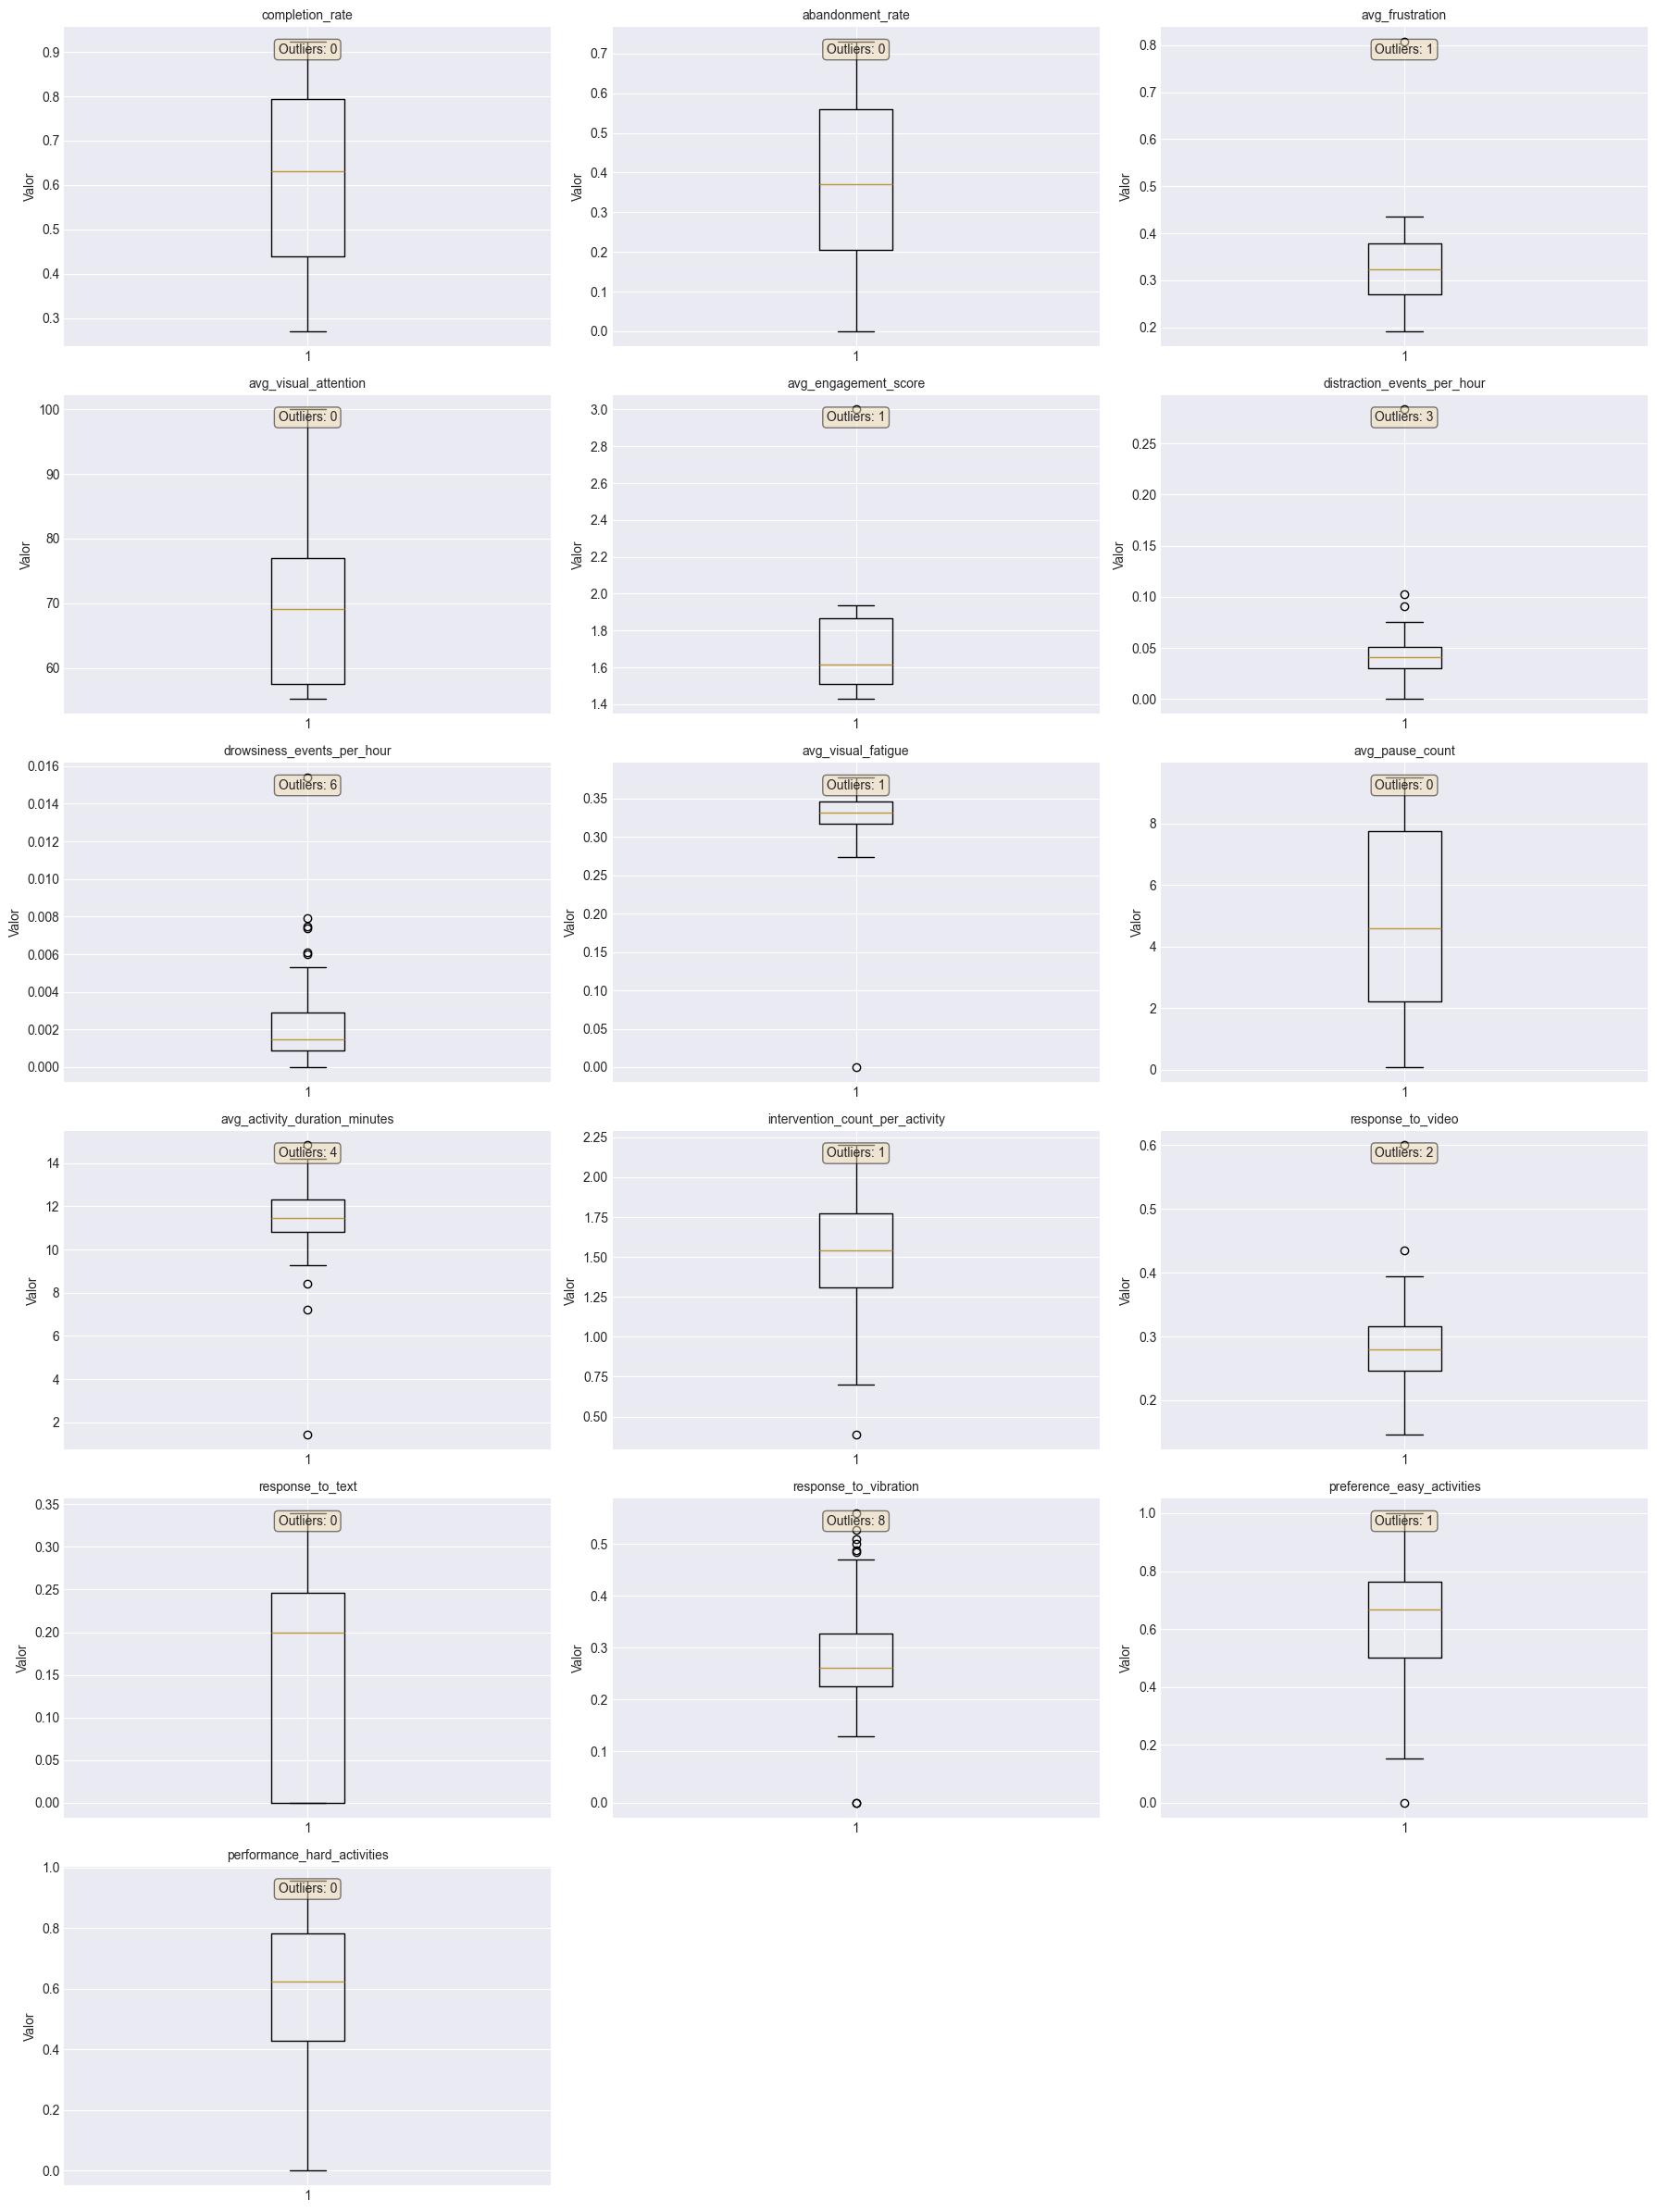

In [20]:
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_ylabel('Valor')
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
    axes[idx].text(0.5, 0.95, f'Outliers: {len(outliers)}', 
                   transform=axes[idx].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('../output/outliers_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Análisis de Segmentos Naturales

In [21]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Completion Rate vs Frustración', 
                    'Atención Visual vs Fatiga Visual',
                    'Distracción vs Pausas',
                    'Engagement vs Intervenciones')
)

fig.add_trace(
    go.Scatter(x=df['completion_rate'], y=df['avg_frustration'], 
               mode='markers', name='Usuarios',
               marker=dict(size=8, opacity=0.6)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df['avg_visual_attention'], y=df['avg_visual_fatigue'], 
               mode='markers', name='Usuarios',
               marker=dict(size=8, opacity=0.6)),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df['distraction_events_per_hour'], y=df['avg_pause_count'], 
               mode='markers', name='Usuarios',
               marker=dict(size=8, opacity=0.6)),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df['avg_engagement_score'], y=df['intervention_count_per_activity'], 
               mode='markers', name='Usuarios',
               marker=dict(size=8, opacity=0.6)),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Relaciones entre Features Clave")
fig.write_html('../output/scatter_relationships.html')
fig.show()

## 7. Preparación de Features para Clustering

In [22]:
features_for_clustering = [
    'completion_rate',
    'avg_frustration',
    'avg_visual_attention',
    'avg_visual_fatigue',
    'distraction_events_per_hour',
    'drowsiness_events_per_hour',
    'avg_pause_count',
    'intervention_count_per_activity',
    'avg_engagement_score',
    'preference_easy_activities'
]

df_clustering = df[['user_id'] + features_for_clustering].copy()

print(f"Features seleccionadas para clustering: {len(features_for_clustering)}")
print("\nEstadísticas de features seleccionadas:")
print(df_clustering[features_for_clustering].describe())

df_clustering.to_csv('../output/features_for_clustering.csv', index=False)
print("\nFeatures guardadas en: output/features_for_clustering.csv")

Features seleccionadas para clustering: 10

Estadísticas de features seleccionadas:
       completion_rate  avg_frustration  avg_visual_attention  \
count       101.000000       101.000000            101.000000   
mean          0.616148         0.320902             67.254226   
std           0.182746         0.087785              8.686288   
min           0.270300         0.191620             55.129902   
25%           0.440000         0.270146             57.485083   
50%           0.630100         0.323011             69.117600   
75%           0.794100         0.379522             76.987289   
max           0.923100         0.807666            100.000000   

       avg_visual_fatigue  distraction_events_per_hour  \
count          101.000000                   101.000000   
mean             0.328564                     0.043756   
std              0.038684                     0.028724   
min              0.000000                     0.000000   
25%              0.317200               

## 8. Conclusiones del EDA

In [23]:
print("CONCLUSIONES DEL ANÁLISIS EXPLORATORIO:")
print("="*60)

print(f"\n1. DATOS GENERALES:")
print(f"   - Total usuarios analizados: {len(df)}")
print(f"   - Features totales: {len(numeric_cols)}")
print(f"   - Features para clustering: {len(features_for_clustering)}")

print(f"\n2. COMPLETION RATE:")
print(f"   - Promedio: {df['completion_rate'].mean():.2%}")
print(f"   - Mediana: {df['completion_rate'].median():.2%}")
print(f"   - Desviación estándar: {df['completion_rate'].std():.2%}")

print(f"\n3. FRUSTRACIÓN:")
print(f"   - Promedio: {df['avg_frustration'].mean():.3f}")
print(f"   - Usuarios con alta frustración (>0.7): {(df['avg_frustration'] > 0.7).sum()}")

print(f"\n4. ATENCIÓN VISUAL:")
print(f"   - Promedio: {df['avg_visual_attention'].mean():.1f}%")
print(f"   - Usuarios con baja atención (<60%): {(df['avg_visual_attention'] < 60).sum()}")

print(f"\n5. DISTRACCIÓN:")
print(f"   - Eventos promedio por hora: {df['distraction_events_per_hour'].mean():.2f}")
print(f"   - Usuarios muy distraídos (>8/hora): {(df['distraction_events_per_hour'] > 8).sum()}")

print(f"\n6. PAUSAS:")
print(f"   - Promedio por actividad: {df['avg_pause_count'].mean():.2f}")
print(f"   - Usuarios con muchas pausas (>6): {(df['avg_pause_count'] > 6).sum()}")

print(f"\n7. INTERVENCIONES:")
print(f"   - Promedio por actividad: {df['intervention_count_per_activity'].mean():.2f}")
print(f"   - Respuesta a video: {df['response_to_video'].mean():.2%}")
print(f"   - Respuesta a texto: {df['response_to_text'].mean():.2%}")
print(f"   - Respuesta a vibración: {df['response_to_vibration'].mean():.2%}")

print("\n" + "="*60)

CONCLUSIONES DEL ANÁLISIS EXPLORATORIO:

1. DATOS GENERALES:
   - Total usuarios analizados: 101
   - Features totales: 16
   - Features para clustering: 10

2. COMPLETION RATE:
   - Promedio: 61.61%
   - Mediana: 63.01%
   - Desviación estándar: 18.27%

3. FRUSTRACIÓN:
   - Promedio: 0.321
   - Usuarios con alta frustración (>0.7): 1

4. ATENCIÓN VISUAL:
   - Promedio: 67.3%
   - Usuarios con baja atención (<60%): 31

5. DISTRACCIÓN:
   - Eventos promedio por hora: 0.04
   - Usuarios muy distraídos (>8/hora): 0

6. PAUSAS:
   - Promedio por actividad: 5.44
   - Usuarios con muchas pausas (>6): 45

7. INTERVENCIONES:
   - Promedio por actividad: 1.53
   - Respuesta a video: 28.51%
   - Respuesta a texto: 16.06%
   - Respuesta a vibración: 27.95%

